<a href="https://colab.research.google.com/github/mraarabzadeh/University_prj/blob/master/start3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/newbit.csv').dropna()
df = df.iloc[[x for x in range(0,20000,10)]]

In [0]:
class Bitcoin(nn.Module):
    def __init__(self,inSize, hiddenSize, outSize,ws):
        super().__init__()
        self.hiddenSize = hiddenSize
        self.inSize = inSize
        lstm = []
        for i,item in enumerate(hiddenSize):
            lstm.append(nn.LSTM(inSize,hiddenSize[i],num_layers=2,dropout=.2))
            inSize = hiddenSize[i]
        self.lstm = nn.ModuleList(lstm)
        self.linear = nn.Linear(hiddenSize[-1], outSize)
        self.ws = ws
        self.reset()
    def reset(self):
        self.hiddenMemory =[]
        for item in self.hiddenSize:
            self.hiddenMemory.append((torch.zeros(2,1,item).cuda(),\
                            torch.zeros(2,1,item).cuda()))
    def forward(self,seq):
        seq=seq.view(self.ws,-1,self.inSize)
        for i,item1 in enumerate(self.hiddenMemory):
            seq ,self.hiddenMemory[i]= self.lstm[i](seq, self.hiddenMemory[i])
        x = self.linear(seq)
        return x[-1]

In [0]:
def make_input(seq,ws):
    output = []
    for item in range(len(seq) - ws):
        output.append( ((seq[item:item+ws].reshape(1,-1)[0].cuda()),\
                        torch.FloatTensor(np.array(seq[item + ws:item + ws+1][-1][-1])).cuda()) )
    return output



In [0]:
WS = 5
instance = Bitcoin(1,[200,300,100],1,WS).cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(instance.parameters(), lr = .01)
torch.manual_seed(33)

In [0]:
traincol = ['Open','High','Low', 'Close', 'Volume_(Currency)', 'Weighted_Price']
resultCol = ['Weighted_Price']

In [0]:
scaler = MinMaxScaler(feature_range=(-20, 20 ))
train_set = np.array(df[resultCol][-500:-100].values.astype(float)).reshape(-1,1)
train_set = scaler.fit_transform(train_set)
train_set = torch.FloatTensor(train_set)
train_set = make_input(train_set, WS)
test = df[resultCol][-100:].values.astype(float).reshape(-1,1)
test = scaler.fit_transform(test)
test = torch.FloatTensor(test)
test = make_input(test,WS)

In [0]:
epoch = 200
optimizer = torch.optim.Adam(instance.parameters(), lr=.0001)
for i in range(epoch):
    for seq, y in train_set:
        instance.reset()
        pred = instance.forward(seq)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    print(i, loss)
    if loss <= .001:
      break

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0 tensor(0.2791, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.0569, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.1854, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.0166, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.0238, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.1424, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.0279, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.1357, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.0815, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.1065, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.0254, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.1255, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0677, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0226, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.1367, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.1018, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0136, 

In [0]:
torch.save(instance.state_dict(),'/content/drive/My Drive/Colab Notebooks/start400_5_3L_R.pn')

In [0]:
instance = Bitcoin(1,[100,200],1,WS)
instance.load_state_dict(torch.load('start1000_360.pn'))
instance = instance.cuda()

In [0]:
# instance.eval()
preds = []
real = []
with torch.no_grad():
    for item, y in train_set:
        instance.reset()

        preds.append(instance.forward(item))
        real.append(y)


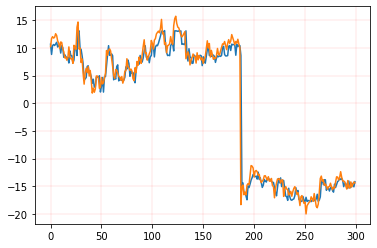

In [0]:
plt.plot(range(300), preds[-300:],)
# plt.show()
plt.grid(color='r', linestyle='-', linewidth=.1, zorder=.1)
# plt.show()
plt.plot(range(300), real[-300:])
plt.show()